#  Introduction

## Big Picture  
We ingest a social graph, learn patterns of who connects with whom using two lightweight graph models (GraphSAGE and LightGCN), and then predict new links—showing not just recommendations but also **why** they make sense through mutual-friend explanations.

---

## Business Application  
This POC illustrates how an organization might power features like:  
- **“People You May Know”** in social media apps  
- **Partnership or collaborator suggestions** in enterprise networks  
- **Targeted networking recommendations** for professional platforms  

By surfacing mutual-friend visualizations, we keep recommendations transparent and build trust with end users.

---

## Pipeline at a Glance  
1. **Data Setup**  
   Load the ego-network, generate real vs. negative edge samples, and split into train/val/test.  
2. **Model Definitions**  
   Implement GraphSAGENet and LightGCN to capture multi-hop neighborhood structure.  
3. **Training & Evaluation**  
   Train both models for 50 epochs, track ROC-AUC & Recall@10, and save checkpoints.  
4. **Explainability & Visualization**  
   For any recommended link, display the shared friends subgraph so stakeholders see exactly **why** that suggestion was made.  


# # SECTION 1: INSTALL DEPENDENCIES
(Run once in your environment)


We need to set up our toolbox before we start. First, we’ll install PyTorch, PyTorch Geometric, and scikit-learn so our code can do deep learning and graph processing.

Then we’ll pull in the matching CUDA builds of PyG’s extensions (torch-scatter, torch-sparse, etc.) to make sure everything runs smoothly on our GPU or CPU.

In [26]:
# Core libraries: PyTorch, PyG, and scikit-learn
!pip install torch torch_geometric scikit-learn

#Find out what version Torch & CUDA you're using
  #print(torch.__version__, torch.version.cuda)

# PyG extensions matching your CUDA/torch version (adjust URLs as needed)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


# SECTION 2: DATASET EXTRACTION
(Run once after downloading facebook.tar.gz)


We’ll unpack the facebook.tar.gz file so we have the SNAP Facebook ego-network ready to load in.

In [27]:
# Create a folder and unzip the archive containing the SNAP ego-Facebook data
!mkdir -p /content/facebook
!tar -xzf /content/facebook.tar.gz -C /content/facebook

# SECTION 3: IMPORTS & DEVICE SETUP


We’ll import pandas for tables, NumPy for math, PyTorch for deep learning, and PyG for graph layers and utilities.

Then we’ll check for a CUDA GPU (faster matrix math!) and default to CPU if none is available.

In [28]:
import os
import time
import pandas as pd
from IPython.display import display
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score

# PyG utilities and layers
from torch_geometric.datasets import SNAPDataset
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn import SAGEConv, GCNConv, LGConv

# Select GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# SECTION 4: DATA LOADING & PREPROCESSING


Prepare our link-prediction splits:

1. We load the Facebook ego-network graph onto our device.
2. Shuffle edges and split into train/val/test (80/10/10). We're randomly reordering friendships so the model is forced to learn and not cheat.
3. For each real edge, we sample a non-edge—this tells the model what “not friends” look like. This is essential so the model can differentiate between the two
4. Attach pos_* and neg_* edge attributes so our code can grab the right slice for each phase.


In [29]:
# 1) Load the Facebook ego-network (first graph only)
dataset = SNAPDataset(root='/content', name='ego-facebook')
data = dataset[0].to(device)

# 2) Shuffle all edges and split into train/val/test (80/10/10)
edge_index = data.edge_index
perm = torch.randperm(edge_index.size(1))
edge_index = edge_index[:, perm]

num_edges = edge_index.size(1)
train_sz = int(0.8 * num_edges)
val_sz   = int(0.1 * num_edges)
test_sz  = num_edges - train_sz - val_sz

# 3) Generate one batch of negative samples for link prediction
src, tar, neg = structured_negative_sampling(edge_index)

# 4) Assign positive and negative edges for each split
#    Positives: edges that exist
#    Negatives: sampled non-edges
splits = {
    'train': (slice(0, train_sz), slice(0, train_sz)),
    'val':   (slice(train_sz, train_sz+val_sz), slice(train_sz, train_sz+val_sz)),
    'test':  (slice(train_sz+val_sz, None), slice(train_sz+val_sz, None)),
}
for split, (p_slice, n_slice) in splits.items():
    setattr(data, f"pos_{split}_edge_index",
            torch.stack([src[p_slice], tar[p_slice]]))
    setattr(data, f"neg_{split}_edge_index",
            torch.stack([src[n_slice], neg[n_slice]]))

/usr/local/lib/python3.11/dist-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([EgoData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


# SECTION 5: MODEL DEFINITIONS

For this notebook, we're using two specifc models:

GraphSAGE: We build two layers that each summarize a user’s neighborhood into a 16-dim profile, then pass it through ReLU. We chose two layers so each user can learn from friends of friends—but not too many hops, to keep it simple.

LightGCN: Another two-layer graph model that mixes all layers uniformly (equal weights). It’s lighter—faster for a quick proof-of-concept—yet still captures multi-hop relationships.

In [30]:
# (A) GraphSAGE: two-layer SAGEConv with ReLU activations
    #GraphSAGE generalizes node features by aggregating neighbor info
class GraphSAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # Input layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return x

# (B) LightGCN: base GCNConv + multiple LGConv layers with uniform weighting
    #LightGCN produces a weighted sum of multi-hop embeddings with no activations.
class LightGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, alpha=None):
        super().__init__()
        # Uniform layer weights by default
        self.alpha = torch.tensor([1. / (num_layers + 1)] * (num_layers + 1)) \
                     if alpha is None else alpha
        # Initial embedding transformation
        self.gcnconv = GCNConv(input_dim, hidden_dim)
        # LGConv propagations
        self.convs = torch.nn.ModuleList([LGConv() for _ in range(num_layers)])
        self.num_layers = num_layers

    def reset_parameters(self):
        self.gcnconv.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        # Initial embedding
        x = self.gcnconv(x, edge_index)
        # Weighted sum of embeddings at each layer
        out = x * self.alpha[0]
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            out = out + x * self.alpha[i + 1]
        return out


# SECTION 6: TRAINING & EVALUATION UTILITIES


We need routines to teach our model, check its progress, and measure how well it ranks real links above fake ones.



1.   pred_with_emb
2.   train_step
3.   compute_roc
4.   recall_at_k

---

1. We score a pair by dot-product of their embeddings (“how similar are their profiles?”).

2. We do one gradient update using binary cross-entropy on real vs. fake edges (real friends vs fake friends)


3. We calculate ROC-AUC to see how well we rank positives above negatives.

4. We check how often the model’s top-10 suggestions contain the true friends.

In [31]:
# 1) Score edges via dot-product of node embeddings
def pred_with_emb(emb, edge_index):
    return torch.sum(emb[edge_index[0]] * emb[edge_index[1]], dim=1)

# 2) Single training step: BCE loss on pos vs. neg edges
      #binary cross-entropy measures how well we distinguish friends from non-friends
def train_step(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    # Compute embeddings using only training positives
    embs = model(data.x, data.pos_train_edge_index)
    pos_logits = pred_with_emb(embs, data.pos_train_edge_index)
    neg_logits = pred_with_emb(embs, data.neg_train_edge_index)
    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones_like(pos_logits), torch.zeros_like(neg_logits)])
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# 3) ROC-AUC on held-out splits
def compute_roc(model, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        embs = model(data.x, data.pos_train_edge_index)
        pos_scores = torch.sigmoid(pred_with_emb(embs, pos_edge_index)).cpu().numpy()
        neg_scores = torch.sigmoid(pred_with_emb(embs, neg_edge_index)).cpu().numpy()
        preds = np.concatenate([pos_scores, neg_scores])
        labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    return roc_auc_score(labels, preds)

# 4) Recall@K: fraction of true neighbors recovered in top-K
@torch.no_grad()
def recall_at_k(model, k=10):
    model.eval()
    embs = model(data.x, data.pos_train_edge_index)
    recalls = []
    num_nodes = data.x.size(0)
    for i in range(num_nodes):
        # True neighbors in the full graph
        true_nbrs = data.edge_index[1][data.edge_index[0] == i].cpu().numpy()
        if len(true_nbrs) < k:
            continue
        # Neighbors seen during training
        train_nbrs = data.pos_train_edge_index[1][
            data.pos_train_edge_index[0] == i].cpu().numpy()
        # Candidate nodes = all except train_nbrs
        candidates = np.setdiff1d(np.arange(num_nodes), train_nbrs)
        pairs = torch.tensor([[i]*len(candidates), candidates],
                             device=device, dtype=torch.long)
        scores = pred_with_emb(embs, pairs).cpu().numpy()
        top_k = candidates[np.argsort(-scores)[:k]]
        recalls.append(len(np.intersect1d(top_k, true_nbrs)) / len(true_nbrs))
    return float(np.mean(recalls)) if recalls else 0.0

# SECTION 7: MAIN TRAINING LOOP


Train both models for 50 epochs, track metrics, and then test.

Then display a neat table of our progress, save the final models, and report final scores.

In [32]:
# Initialize models
models = {
    'GraphSAGE': GraphSAGENet(data.num_node_features, hidden_channels=16).to(device),
    'LightGCN': LightGCN(data.num_node_features, hidden_dim=16).to(device),
}

# Train and evaluate each model
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    history = []  # to store per-epoch metrics

    print(f"\n=== Training {name} ===")
    for epoch in range(1, 51):
        loss    = train_step(model, optimizer, data)
        val_roc = compute_roc(model, data.pos_val_edge_index, data.neg_val_edge_index)
        val_rec = recall_at_k(model, k=10)

        # Record metrics
        history.append({
            'Epoch':     epoch,
            'Loss':      loss,
            'ROC-AUC':   val_roc,
            'Recall@10': val_rec
        })

    # Display training history in a nice table
    df = pd.DataFrame(history)
    display(df.style.format({
        'Loss':      '{:.4f}',
        'ROC-AUC':   '{:.4f}',
        'Recall@10': '{:.4f}'
    }))

    # Save model checkpoint
        #so you can reload and analyze the best model later
    os.makedirs('checkpoints', exist_ok=True)
    torch.save(model.state_dict(), f'checkpoints/{name}.pth')

    # Final evaluation on test split
    test_roc = compute_roc(model, data.pos_test_edge_index, data.neg_test_edge_index)
    test_rec = recall_at_k(model, k=10)
    print(f"*** {name} Test ROC-AUC: {test_roc:.4f}, Recall@10: {test_rec:.4f} ***")



=== Training GraphSAGE ===


,Epoch,Loss,ROC-AUC,Recall@10
0,1,0.7064,0.6416,0.0148
1,2,0.6912,0.6335,0.0155
2,3,0.6863,0.6695,0.0220
3,4,0.6718,0.7354,0.0314
4,5,0.6602,0.7446,0.0332
5,6,0.6484,0.7466,0.0299
6,7,0.6450,0.7855,0.0271
7,8,0.6363,0.7924,0.0259
8,9,0.6339,0.7940,0.0256
9,10,0.6298,0.7977,0.0268


*** GraphSAGE Test ROC-AUC: 0.8244, Recall@10: 0.0539 ***

=== Training LightGCN ===


,Epoch,Loss,ROC-AUC,Recall@10
0,1,0.7165,0.7713,0.0577
1,2,0.6974,0.7395,0.0548
2,3,0.6867,0.7422,0.0578
3,4,0.6849,0.7523,0.0551
4,5,0.6692,0.7636,0.0537
5,6,0.6486,0.7853,0.0562
6,7,0.6313,0.7899,0.0558
7,8,0.6165,0.7925,0.0558
8,9,0.6035,0.7983,0.0547
9,10,0.5906,0.8039,0.0523


*** LightGCN Test ROC-AUC: 0.8599, Recall@10: 0.0594 ***


# SECTION 8: MUTUAL-FRIEND EXPLAINER & VISUALIZATION


Explains application to a non-technical audience alongside with a visual

Build a small graph illustrating why the model recommends node j to i, by highlighting their mutual friends.


---


We want to show our recommendation in human terms—“you and user j both know these friends”—and draw a small graph.

Model says: You should connect with user 193.
Because you both share these mutual friends:
  - User 298
  - User 52
  - User 345


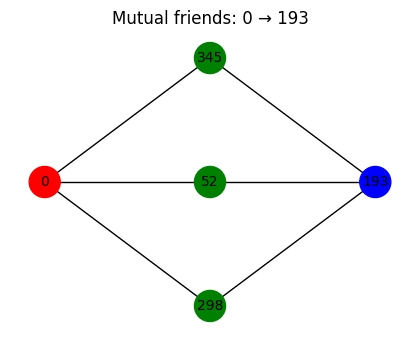

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Pick a source node `i` and a recommended node `j`
i = 0
# (e.g., take the top recommendation from your earlier code)
j = recommended_nodes[0]

# 1) Extract neighbors from the full edge list
e_full = data.edge_index.cpu().numpy()
src_full, dst_full = e_full
nbrs_i = set(dst_full[src_full == i])
nbrs_j = set(dst_full[src_full == j])

# 2) Compute mutual friends (up to 3 examples)
mutuals = list(nbrs_i & nbrs_j)[:3]

# 3) Print a text-based explanation
print(f"Model says: You should connect with user {j}.")
print("Because you both share these mutual friends:")
for m in mutuals:
    print(f"  - User {m}")

# 4) Build a small subgraph for visualization
G = nx.Graph()
# Add focal nodes
graph_nodes = [i, j] + mutuals
for n in graph_nodes:
    G.add_node(n)
# Add edges from each focal node to each mutual friend
for m in mutuals:
    G.add_edge(i, m)
    G.add_edge(j, m)

# 5) Fix node positions (left=source, right=recommendation, mutuals in center)
pos = {i: (-1, 0), j: (1, 0)}
ys = np.linspace(-0.5, 0.5, len(mutuals))
for idx, m in enumerate(mutuals):
    pos[m] = (0, ys[idx])

# 6) Color-code nodes: red=source, blue=rec, green=mutuals
colors = [
    'red' if n == i else
    'blue' if n == j else
    'green'
    for n in G.nodes()
]

# 7) Draw the graph
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, font_size=10)
plt.title(f"Mutual friends: {i} → {j}")
plt.axis('off')
plt.show()